In [1]:
# DEPENDENCIES
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# OWN MODULES
from datapipeline import init_database, query_from_db
from helpers import create_decimal_timedata, pretty_plot, plot_locations

#### ----------------------------------------------------------------------------
## Problem (1) - Create a short data pipeline for the Helsinki building data, i.e. create an ETL for the data from the source to an SQL table.

#### ----------------------------------------------------------------------------

### The data pipeline can be found from the [datapipeline library](https://github.com/serveri24h/reagle_pre_assignment/tree/main/datapipeline). The most important parts of the code are in the [api.py](https://github.com/serveri24h/reagle_pre_assignment/tree/main/datapipeline/api.py) file. The data is requested from the url 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs' using [this xml post request](https://github.com/serveri24h/reagle_pre_assignment/tree/main/datapipeline/requests/fetch_all_data.xml). 

### The database is then initialised if it does not already exist. 

In [2]:
if not os.path.exists('databases/reagle.db'):
    init_database()

### Next, we will test that the database exists and can be queried from. For example, we can query for very small buildings (<20m^2) in with area code 00550.

In [3]:
query_from_db('SELECT * FROM reagle WHERE floor_area<20 AND zipcode="00550"')

,north_coordinate,east_coordinate,construction_date,floor_area,utility,zipcode
id,,,,,,
39362,6675801,25498164,1993-12-31,5.0,941,00550
50008,6675762,25497731,1989-12-31,16.0,941,00550


## ----------------------------------------------------------------------------
## Problem (2) - Calculate how the fraction of residential buildings in all buildings (floor area) has developed over the last three years.
## ----------------------------------------------------------------------------

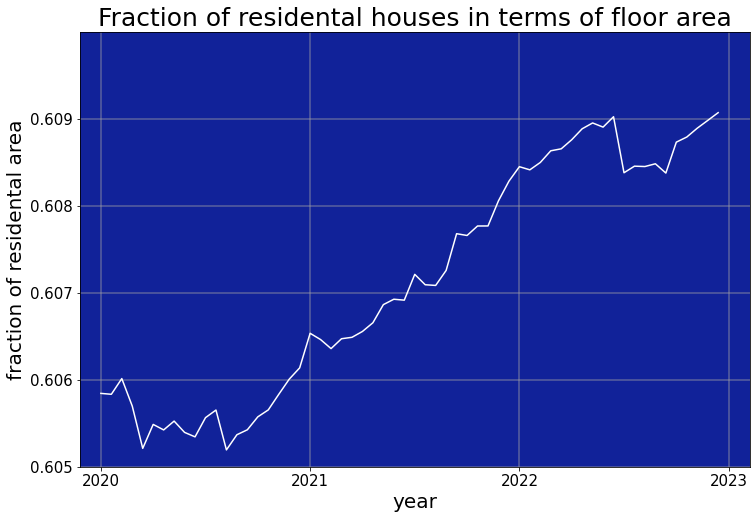

In [4]:
# All the data is fetched from the local database
data = query_from_db('SELECT * FROM reagle')


# Additional column that gives the time of construction as a float is added
# The procedure is done to make visualization of the time line data easier
data['decimal_construction_date'] = create_decimal_timedata(data)


# Next, a list of keys between '000'-'099' that represent residental buildings is generated
# (The list is needed to filter the residental buildings from all buildings)
residental_keys = ['0'*(3-len(str(i)))+str(i) for i in range(100)]


# Empty lists for holding total floor areas are initialised
A_residential, A_all_buildings = [],[]


# Years 2020-2023 are iterated in small time intervals and the floor area 
# for residental and all buildings and computed
T = np.arange(2020, 2023, 0.05)
for t in T:
    
    # filter buildings that that are constructed before t
    building_in_t = data.loc[data['decimal_construction_date'] < t]
    
    # Add the total area to the list
    A_all_buildings.append( building_in_t['floor_area'].sum() )
    
    # from the the previous buildings filter the ones that are residential and append to the corresponding list
    A_residential.append( building_in_t.loc[building_in_t['utility'].isin(residental_keys)]['floor_area'].sum() )

# The fraction of area determined by the residetal buildings is computed
prosentages = np.array(A_residential)/np.array(A_all_buildings)

# And final results are plotted
pretty_plot(T,prosentages)

### Based on the plot above, we can see that the fraction of floor area in residential buildings has risen approximately 0.3%. We can also compute the exact fractions for the last three years as follows. (2023 refers to the present moment)

In [5]:
for y in range(2020,2023+1):
    d = data.loc[data['decimal_construction_date'] < y]
    tot_area = d['floor_area'].sum()
    res_area = d.loc[d['utility'].isin(residental_keys)]['floor_area'].sum()
    print(f"year {y}: \n total area: {tot_area:.0f}m^2 <-> residental area {res_area:.0f}m^2 <-> fraction: {100*res_area/tot_area:.2f}%\n")

year 2020: 
 total area: 49166932m^2 <-> residental area 29787493m^2 <-> fraction: 60.58%

year 2021: 
 total area: 49999394m^2 <-> residental area 30326387m^2 <-> fraction: 60.65%

year 2022: 
 total area: 50689266m^2 <-> residental area 30841905m^2 <-> fraction: 60.85%

year 2023: 
 total area: 51266056m^2 <-> residental area 31224843m^2 <-> fraction: 60.91%





## ----------------------------------------------------------------------------
## Problem (3) -  visualize the current office building stock for a zip code area 00100 in Helsinki.
## ----------------------------------------------------------------------------

### The location given the n-coordinate and, e-coordinate of all buildings with utility-code between 100-200 and postal code of 00100 are plotted. The size of the plot is based on the floor size and the color is based on the utility. The bright green indicates office building.

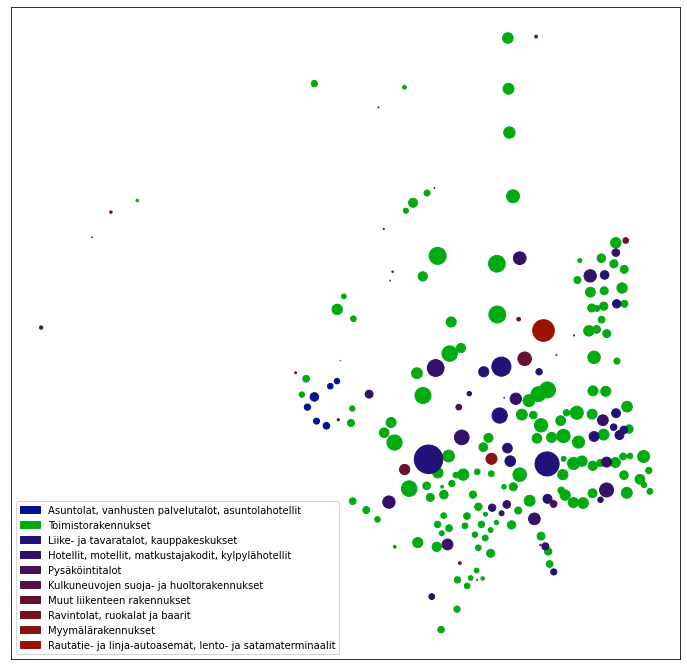

In [6]:
# We will query for data using the zipcode in where clause 
# along with a like clause that checks if the utility code begins with '1'
data = query_from_db('SELECT * FROM reagle WHERE zipcode="00100" AND utility LIKE "1%"')

# Next, the data is ploted
plot_locations(data)

## ----------------------------------------------------------------------------
## Problem (4) -  explain the code and think a about the maintenance and how to improve the scripts.
## ----------------------------------------------------------------------------
## (a) Explanations
### The source code is commented and some of the code is explained in this notebook.
## (b) Improvements:
### * Parameterisation of SQL-queries and other safety measures to prevent SQL-injections.
### * SQLite is a very lightweight SQL-library, and might not scale well. Therefore, MySQL server etc. might be requirement. The database could be accessed from a cloud server such as Linode or AWS.
### * An update functionaloty could be added to the local database. That way the data would stay up to date.
### * The web api connections could be tried several times in case the first time fails.
### * Currently there is no possibility for creating, updating or deleting elements from the local database using the provided API. If the project grows those methods might require implementation.
### * More unit testing and more testing for potential errors in runtime.
### * Lots of other things :D